SELECT winner, loser, __updatetime from CONTESTS 
WHERE game='madden19'
AND type='H'
AND status='completed'
LIMIT 500;

In [9]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline

def moving_average(array, window=3):
    """
    a : array
    n : int, size of window
    """
    ret = np.cumsum(array, dtype=float)
    ret[window:] = ret[window:] - ret[:-window]
    return ret[window - 1:] / window



def _update_counter(player):
    if player in counter.keys():
        counter[player] += 1
    else:
        counter[player] = 1
        
class Player(object):
    def __init__(self, name):
        self.name = name
        self.ranking = Rating(np.random.normal(50, 8))
        self.count = 0
        
BETA = 8.333

def win_probability(greater, lesser):
    # # https://github.com/sublee/trueskill/issues/1
    exp = (greater.mu - lesser.mu) / BETA
    n = 4. ** exp
    return n / (n + 1)

from trueskill import Rating, quality_1vs1, rate_1vs1
import numpy as np
from tqdm import tqdm



def population2hist():
    count = {}
    for k,v in population.items():
        if k not in count.keys():
            count[k] = 1
        else:
            count[k] += 1

    histogram = {}
    for k, v in count.items():
        if v in histogram.keys():
            histogram[v] += 1
        else:
            histogram[v] = 1
    return histogram

def idx2player(idx):
    if idx not in population:
        population[idx] = Player(idx)
    return population[idx]

In [6]:
import pandas as pd
import sqlalchemy
from sqlalchemy import create_engine
from tqdm import tqdm

POSTGRES_ADDRESS = 'db.panoply.io' ## INSERT YOUR DB ADDRESS IF IT'S NOT ON PANOPLY
POSTGRES_PORT = '5439'
POSTGRES_USERNAME = 'vin.tang@gmail.com' ## CHANGE THIS TO YOURPANOPLY/POSTGRES USERNAME
POSTGRES_PASSWORD = 'Cobalt27!' ## CHANGE THIS TO YOUR PANOPLY/POSTGRES PASSWORD
POSTGRES_DBNAME = 'playerslounge_prod' ## CHANGE THIS TO YOUR DATABASE NAME

postgres_str = ('postgresql://{username}:{password}@{ipaddress}:{port}/{dbname}'.format(username=POSTGRES_USERNAME,
password=POSTGRES_PASSWORD,
ipaddress=POSTGRES_ADDRESS,
port=POSTGRES_PORT,
dbname=POSTGRES_DBNAME))

cnx = create_engine(postgres_str)

query = """SELECT winner, loser, __updatetime from CONTESTS 
WHERE console_game='ps4-madden21' and type='H' and status='completed'
ORDER by __updatetime ASC LIMIT 10000;"""

df = pd.read_sql_query(query, cnx)
df.shape

(10000, 3)

In [7]:
df.head()

,winner,loser,__updatetime
0,443992607815436,7038695774196162,2020-08-21 19:15:34.342
1,4460130662083057,2440478575721950,2020-08-21 19:15:34.342
2,1423306798710215,3760128336573619,2020-08-21 20:10:45.923
3,1830401092194768,5564384449600533,2020-08-21 20:10:45.923
4,5441303459712592,4500624820594460,2020-08-21 20:10:45.923


In [10]:
population = {}
history = []
count = 0

for i, row in tqdm(df.iterrows()):
    
    # check if winner exists and return P
    p1 = idx2player(row['winner'])
    p2 = idx2player(row['loser'])
    
    p1.count += 1
    p2.count += 1
            
    # generate prediction based on trueskill - where we correct?
    # prob = win_probability(p1.ranking, p2.ranking)  # winning probability for p1
    # pred = np.random.uniform() < prob
    if p1.count > 2 and p2.count > 2:
        pred = p1.ranking.mu > p2.ranking.mu
        history.append(int(pred))
        count += 1
    
    # update players 
    p1.ranking, p2.ranking = rate_1vs1(p1.ranking, p2.ranking)

10000it [00:04, 2474.37it/s]


Text(0, 0.5, 'Prediction Accuracy')

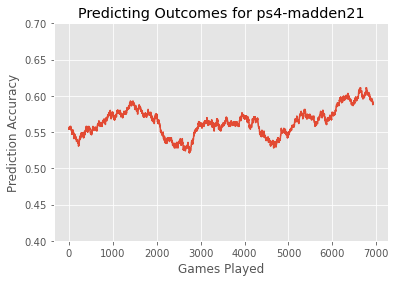

In [11]:
d = moving_average(history, window=int(len(history)/10))
plt.plot(d)
plt.ylim(.4, .7)

plt.title("Predicting Outcomes for ps4-madden21")
plt.xlabel("Games Played")
plt.ylabel("Prediction Accuracy")

<a list of 10 Patch objects>

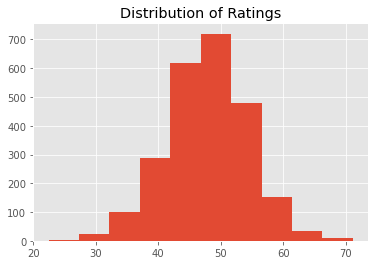

In [87]:
plt.title('Distribution of Ratings')
plt.hist(list(map(lambda x: x.ranking.mu, population.values())))[2]